In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [3]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [4]:
in_columns = ['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = ['0', '1', '2']
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)

In [5]:
BATCH_SIZE = int(1e3)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.2

In [6]:
def split_and_scale(data):
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    pid_test = np.array(data_test["pid"])
    
    data_train.drop("pid", axis=1, inplace=True)
    data_val.drop("pid", axis=1, inplace=True)
    data_test.drop("pid", axis=1, inplace=True)
    
    scaler = RobustScaler().fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.values),
                            columns=data_test.columns)
    
    data_test["pid"] = pid_test
    
    return data_train, data_val, data_test, scaler

In [7]:
data_all_pids = pd.read_csv("./LHCb_PID_Compression/df_full_encoded_ratio10_new_3.csv").drop('Unnamed: 0', axis=1)
data_pid_a = data_all_pids[data_all_pids["pid"]=='a']
data_pid_b = data_all_pids[data_all_pids["pid"]=='b']
data_pid_c = data_all_pids[data_all_pids["pid"]=='c']
data_pid_d = data_all_pids[data_all_pids["pid"]=='d']
data_pid_e = data_all_pids[data_all_pids["pid"]=='e']

In [8]:
data_pid_a.head()

,0,1,2,pid,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0
1,-0.197080,0.330315,-0.566860,a,1856.50,2.257560,1.0,1.0,1.0
14,-0.472994,-0.397662,0.043416,a,9132.44,4.519257,1.0,1.0,-999.0
18,-0.188955,-0.002554,-0.364291,a,4187.57,2.633193,-999.0,-999.0,1.0
38,-0.480064,-0.230109,0.154825,a,5277.06,3.911720,1.0,1.0,1.0
45,-0.197892,0.021600,-0.563916,a,1521.03,2.091014,-999.0,-999.0,1.0


In [9]:
data_train, data_val, data_test, scaler = split_and_scale(data_pid_a)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Let's look at the distributions of the features:

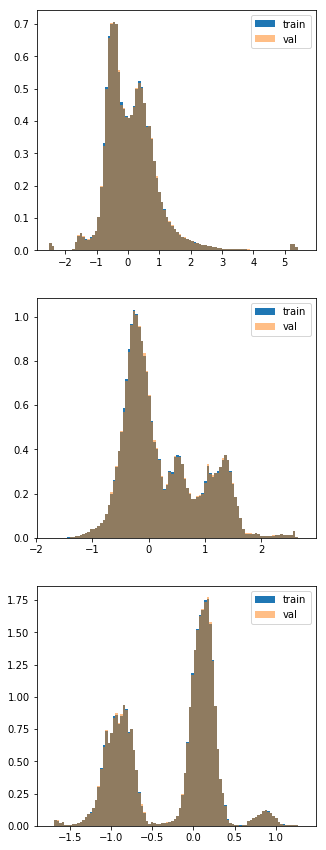

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
for INDEX, ax in zip((0, 1, 2), axes):
    _, bins, _ = ax.hist(data_train.values[:, INDEX], bins=100, label="train", density=True)
    ax.hist(data_val.values[:, INDEX], bins=bins, label="val", alpha=0.5, density=True)
    ax.legend()
plt.show()

## Building GAN

In [13]:
data_train = data_train[in_columns+out_columns]
data_val = data_val[in_columns+out_columns]

data_test = data_test[in_columns+out_columns]

In [14]:
def get_tf_dataset(dataset, batch_size):
    shuffler = tf.contrib.data.shuffle_and_repeat(dataset.shape[0])
    suffled_ds = shuffler(tf.data.Dataset.from_tensor_slices(dataset))
    return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()

In [15]:
tf.reset_default_graph()

In [16]:
def get_dense(num_layers):
    return [ll.Dense(128, activation='relu') for i in range(num_layers)]

CRAMER_DIM = 128

critic = keras.models.Sequential(
        [ll.InputLayer([OUT_DIM + IN_DIM])] + get_dense(3) +
            [ll.Dense(CRAMER_DIM)])
generator = keras.models.Sequential(
        [ll.InputLayer([LATENT_DIMENSIONS + IN_DIM])] + get_dense(3) +
            [ll.Dense(OUT_DIM)])

In [17]:
X_train_full = data_train[in_columns+out_columns]
X_train_input = data_train[in_columns]

X_train_input_tf1 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_input_tf2 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_full_tf = get_tf_dataset(X_train_full, BATCH_SIZE)

In [18]:
def cramer_critic(x, y):
    discriminated_x = critic(x)
    return tf.norm(discriminated_x - critic(y), axis=1) - tf.norm(discriminated_x, axis=1)

In [19]:
noise_1 = tf.random_normal([tf.shape(X_train_input_tf1)[0], LATENT_DIMENSIONS], name='noise1')
noise_2 = tf.random_normal([tf.shape(X_train_input_tf2)[0], LATENT_DIMENSIONS], name='noise2')

generated_out_1 = generator(tf.concat([noise_1, tf.cast(X_train_input_tf1, tf.float32)], axis=1))
generated_full_1 = tf.concat([tf.cast(X_train_input_tf1, tf.float32), generated_out_1], axis=1)

generated_out_2 = generator(tf.concat([noise_2, tf.cast(X_train_input_tf2, tf.float32)], axis=1))
generated_full_2 = tf.concat([tf.cast(X_train_input_tf2, tf.float32), generated_out_2], axis=1)

In [20]:
generator_loss = tf.reduce_mean(cramer_critic(tf.cast(X_train_full_tf, tf.float32), generated_full_2)
                                - cramer_critic(generated_full_1, generated_full_2))

In [21]:
with tf.name_scope("gradient_loss"):
    alpha = tf.random_uniform(shape=[tf.shape(X_train_full_tf)[0], 1], minval=0., maxval=1.)
    interpolates = alpha*tf.cast(X_train_full_tf, tf.float32) + (1.-alpha)*generated_full_1
    disc_interpolates = cramer_critic(interpolates, generated_full_2)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
    gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

In [22]:
tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32)/1e4)
critic_loss = lambda_tf*gradient_penalty - generator_loss
learning_rate = tf.train.exponential_decay(1e-3, tf_iter, 100, 0.98)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
critic_train_op = optimizer.minimize(critic_loss, var_list=critic.trainable_weights)
generator_train_op = tf.group(
    optimizer.minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

In [23]:
tf.summary.scalar("critic_loss", tf.reshape(critic_loss, []))
tf.summary.scalar("generator_loss", tf.reshape(generator_loss, []))
tf.summary.scalar("learning_rate", learning_rate)
tf.summary.scalar("lambda", lambda_tf)
merged_summary = tf.summary.merge_all()

In [24]:
N_VAL = int(1e4)
validation_np = data_val.sample(N_VAL).values

In [25]:
data_val.sample(N_VAL).head()

,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,0,1,2
294353,0.545179,0.017942,-1000.0,-1000.0,0.0,0.467560,0.574403,-0.872315
340827,-0.213449,0.142929,0.0,0.0,0.0,-0.385341,-0.243230,0.058674
77215,-0.277182,-1.079081,-1000.0,-1000.0,0.0,0.362922,0.623170,-0.866965
208988,-0.250743,-0.252881,0.0,0.0,0.0,-1.665193,0.672155,0.896772
140903,0.492614,0.548681,0.0,0.0,-1000.0,-0.153565,0.070584,0.094731


In [26]:
var_init = tf.global_variables_initializer()
weights_saver = tf.train.Saver()

In [27]:
tf.get_default_graph().finalize()

## Training GAN

In [31]:
MODEL_NAME = "GAN_Kramer_dim3_bs1e3_l3_ld3_n128_pida_new"
LOGDIR = "/mnt/tgaintseva/compression/tensorboard_logdir"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(1e5)
VALIDATION_INTERVAL = 100
MODEL_WEIGHTS_FILE = "weights/%s.ckpt" % MODEL_NAME
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS)

In [32]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 34,563
Trainable params: 34,563
Non-trainable params: 0
_________________________________________________________________


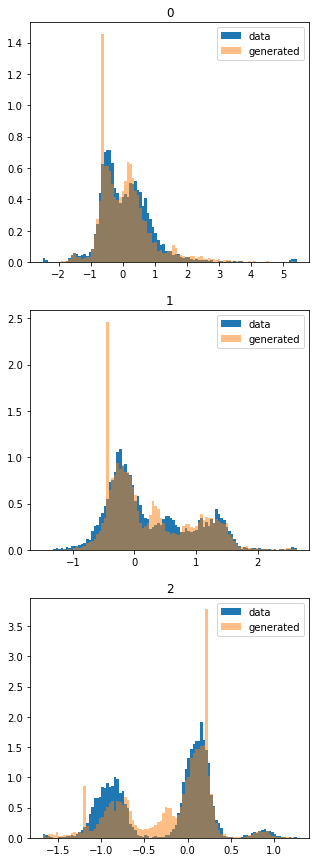

KeyboardInterrupt: 

In [37]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    for i in range(TOTAL_ITERATIONS):
        for j in range(critic_policy(i)):
            sess.run(critic_train_op)
        train_summary, _, interation = sess.run([merged_summary, generator_train_op, tf_iter])
        train_writer.add_summary(train_summary, interation)
        if i % VALIDATION_INTERVAL == 0:
            clear_output(False)
            test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
                X_train_input_tf1: validation_np[:, :len(in_columns)],
                X_train_input_tf2: validation_np[:, :len(in_columns)], X_train_full_tf: validation_np})
            try:
                fig, axes = plt.subplots(3, 1, figsize=(5, 3*5))
                for INDEX, ax in zip((0, 1, 2), axes):
                    _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
                    ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
                    ax.legend()
                    ax.set_title(out_columns[INDEX])
                plt.show()
                fig.savefig('./LHCb_PID_Compression/plots/{}.png'.format(MODEL_NAME))
            except Exception as e:
                print(e)
                weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
                continue
            
            test_writer.add_summary(test_summary, interation)
            weights_saver.save(sess, MODEL_WEIGHTS_FILE)

Saving:

In [33]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    sess.graph._unsafe_unfinalize()
    tf.saved_model.simple_save(sess, os.path.join(
        "exported_model", MODEL_NAME), inputs={"x": X_train_input_tf1}, outputs={"dlls": X_train_full_tf})
    tf.get_default_graph().finalize()
from sklearn.externals import joblib
joblib.dump(scaler, os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl")

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim9_bs5e3_l7_ld10.ckpt


AssertionError: Export directory already exists. Please specify a different export directory: exported_model/GAN_Kramer_dim9_bs5e3_l7_ld10

Look at the result distributions:

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim3_bs1e3_l3_ld3_pida_new.ckpt


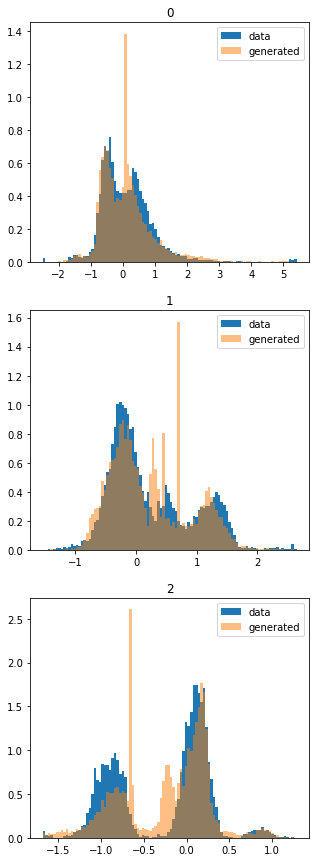

In [31]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: validation_np[:, :len(in_columns)],
        X_train_input_tf2: validation_np[:, :len(in_columns)], X_train_full_tf: validation_np})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim3_bs1e3_l3_ld3_pida_new.ckpt


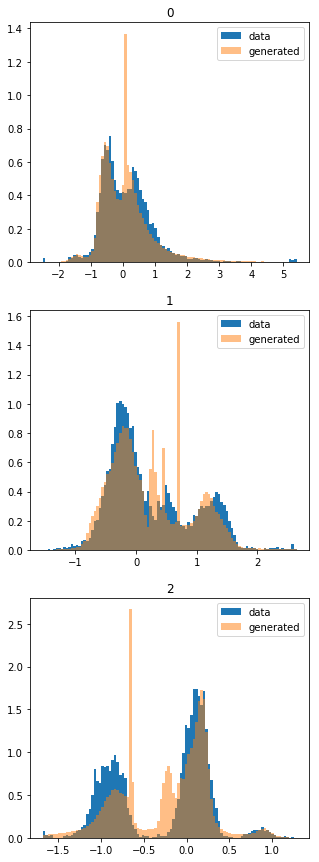

In [32]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: data_test.values[:, :len(in_columns)],
        X_train_input_tf2: data_test.values[:, :len(in_columns)], X_train_full_tf: data_test})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

In [33]:
df_temp_enc = pd.DataFrame(test_generated, columns=out_columns)
df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, data_test[['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']]], axis=1), columns=out_columns+['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
df_temp_full_enc['pid'] = ['a']*len(df_temp_full_enc)
df_temp_full_enc.to_csv("df_GAN_dim3_new_pid{}.csv".format('a'), index=None)

In [44]:
x = pd.read_csv("df_GAN_dim3_pid{}.csv".format('a'))
x.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,5.017660,0.665188,-0.323724,-0.426868,0.089886,0.0,-1000.0,0.0,a
1,-0.523247,-0.556778,0.302377,0.467743,0.039242,0.0,0.0,0.0,a
2,6.743898,-0.747245,-0.986966,-0.466620,-0.404134,0.0,-1000.0,0.0,a
3,0.174981,-0.262415,0.084323,3.284162,-0.038758,0.0,0.0,0.0,a
4,-0.091463,-0.040325,-0.017265,-0.194748,0.081563,0.0,0.0,0.0,a


## XGBoost for PID Classification

In [25]:
from helpers import *

In [26]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    sess.graph._unsafe_unfinalize()
    tf.get_default_graph().finalize()

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim9_bs5e3_l7_ld10.ckpt


Prepare data:

In [27]:
data_test_input = data_test[in_columns]
data_test_out = data_test[out_columns]
data_test_full = data_test[in_columns+out_columns]
pid_test = data_test["pid"]

Check one test
sample:

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim9_bs5e3_l7_ld10.ckpt


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


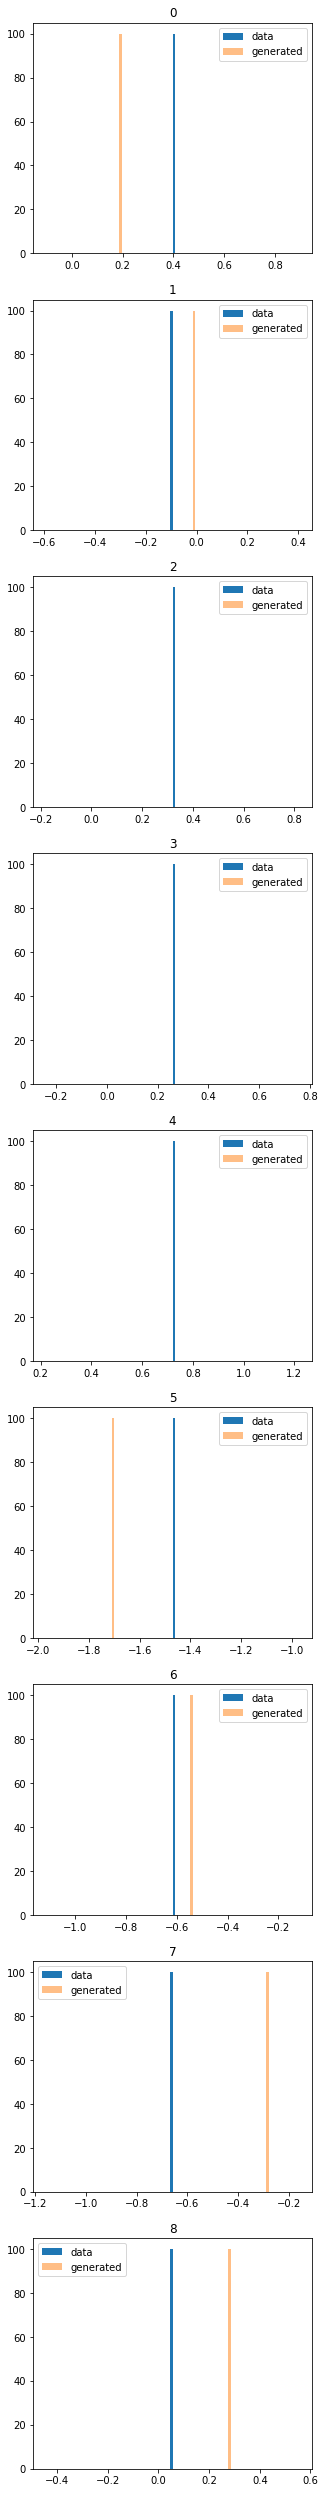

In [28]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
                X_train_input_tf1: np.array(data_test_input)[0].reshape(1, 5),
                X_train_input_tf2: np.array(data_test_input)[0].reshape(1, 5), 
                X_train_full_tf: np.array(data_test_full)[0].reshape(1, 5+9)})
    fig, axes = plt.subplots(9, 1, figsize=(5, 45))
    for INDEX, ax in zip((0, 1, 2, 3, 4, 5, 6, 7, 8), axes):
        _, bins, _ = ax.hist(data_test_full.values[0, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

In [29]:
np.array(data_test_out.iloc[0])

array([ 0.39685412, -0.0945747 ,  0.32033743,  0.25892663,  0.71986878,
       -1.47062556, -0.61722127, -0.65867759,  0.05625451])

In [30]:
test_generated[0]

array([ 0.19285549, -0.00776903, -0.9711839 , -0.5771288 , -0.47862443,
       -1.7085125 , -0.54214936, -0.28793222,  0.2821016 ], dtype=float32)

In [46]:
data_test_out["pid"] = pid_test
pd.DataFrame(data_test_out).to_csv("data_test_out.csv")

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
tg = pd.DataFrame(test_generated)
tg["pid"] = pid_test
tg.to_csv("test_generated.csv")

Check all test inputs:

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim9_bs5e3_l7_ld10.ckpt


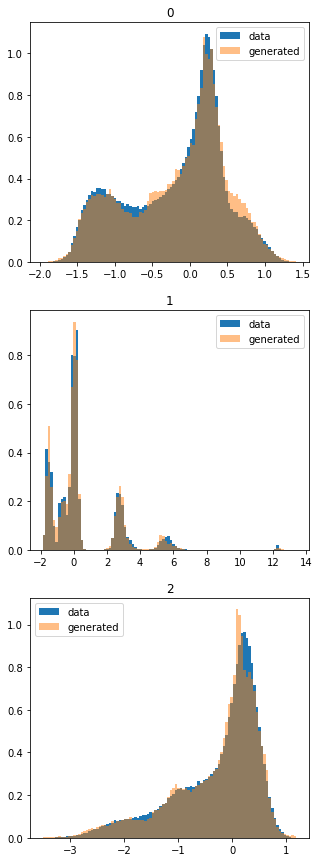

In [31]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
                X_train_input_tf1: data_test_input,
                X_train_input_tf2: data_test_input, X_train_full_tf: data_test_full})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

Split to train/test for xgboost:

In [32]:
le = LabelEncoder()
y = le.fit_transform(pid_test)

In [33]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(data_test_full.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = np.array(data_test_out)[idx_train_clf], np.array(data_test_out)[idx_test_clf]
X_train_gen, X_test_gen = np.array(test_generated)[idx_train_clf], np.array(test_generated)[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

In [32]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [33]:
path_to_metrics = './metrics/'
metrics_dir_name = MODEL_NAME

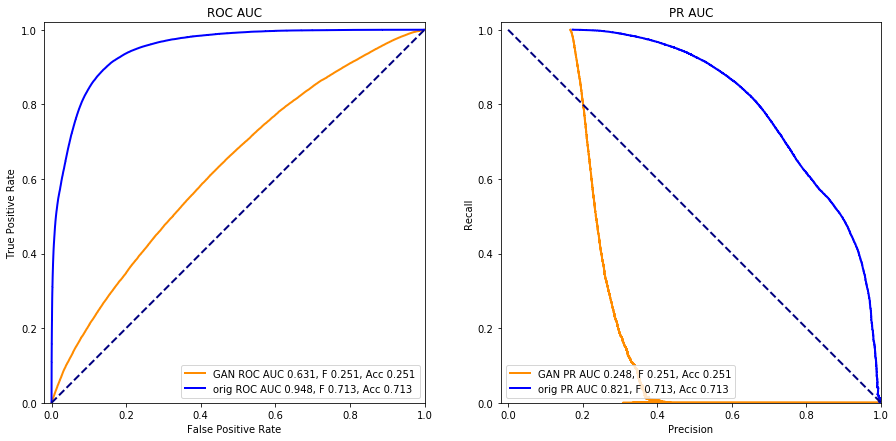

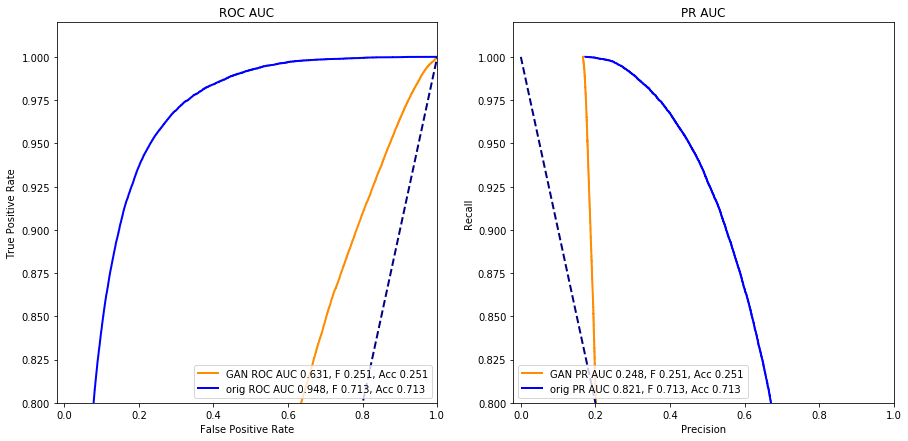

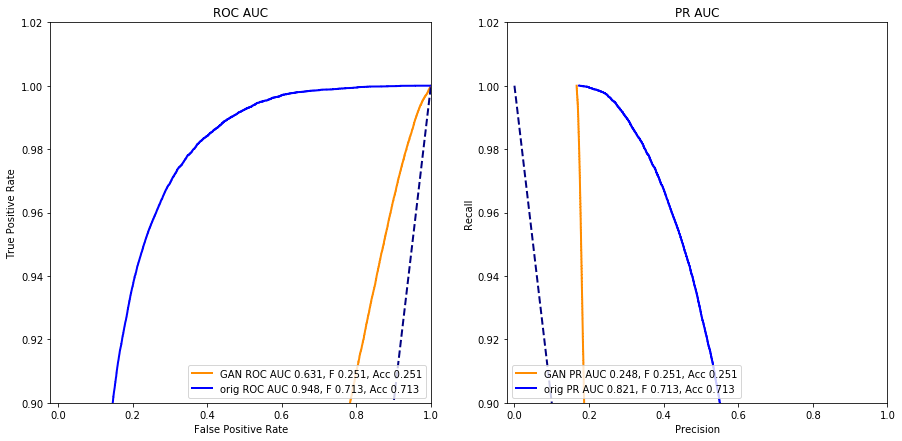

100%|██████████| 2/2 [01:50<00:00, 55.41s/it]


In [36]:
from tqdm import tqdm
for encoding_dim in tqdm(["GAN", "orig"]):
    clf_name = "XGBoost_{}".format(encoding_dim)
    clf = xgb.XGBClassifier(nthread=-1, seed=111)
    
    if encoding_dim == "orig":
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)
    else:
        clf.fit(X_train_gen, y_train)
        y_proba = clf.predict_proba(X_test_gen)
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred = np.argmax(y_proba, axis=1)
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y_test):
        idx = np.where(y_test == pid_label)[0]
        cur_y = np.where(y_test == pid_label, np.ones_like(y_test), np.zeros_like(y_test))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y_test, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y_test, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))